In [2]:
import matplotlib
import numpy as np
from scipy.stats import logistic
from scipy.optimize import minimize
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy.io
import gc
import datetime
import time
import mat73
import hdf5storage
import random
import matplotlib
import _spin_params as spin_pars
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left, find_nearest_sorted
from _steady_state import a_steady, a_steady_with_sz
from _mbes import mbes, mbes_soc
from _do_calculation import solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay
# matplotlib.pyplot.switch_backend('nbagg')
# %qtconsole

In [3]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr
kappa = np.pi*fr/quali  # HWHM
delta = spin_pars.delta  # detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac  # detuning drive to cavity wc-wp
gperp = spin_pars.gperp  # HWHM
gpar = spin_pars.gpar  # 0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins  # 701#5000#20
g_number = spin_pars.g_number  # how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)

19.629990368543535


In [4]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)


x_start = 5
x_stop = 20  # µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

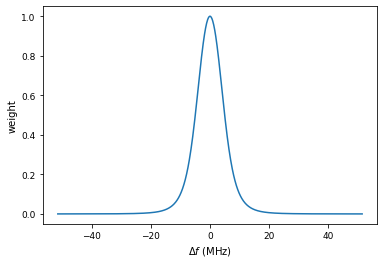

In [5]:
spins, gs, pdf = create_spins_inhomo_g(gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\\Delta f$ (MHz)')
plt.ylabel('weight');
#%qtconsole

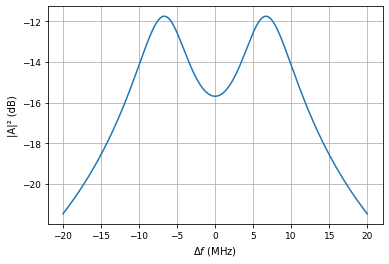

In [6]:
initsteady = (0.001,0.001)
fstart = 20
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.0001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)');
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi
plt.grid(True)

### Fit to data

In [7]:
file_powerscan = "/home/andreas/Physics/reference_traces/referenceTrace_24mK_loop1A_2subs_4.mat"
data_ps = mat73.loadmat(file_powerscan);
iq_data_ps_raw = np.asarray(data_ps['IQdata_scan'])
for i, val in enumerate(iq_data_ps_raw):
    iq_data_ps_raw[i] = val-np.mean(val[-1000:,:], axis=0)
if len(iq_data_ps_raw) > 1:
    iq_data_ps = np.mean(iq_data_ps_raw, axis=0)
else:
    iq_data_ps = np.asarray(data_ps['IQdata_scan'])[0]
pl_idx = 5000
ps_idx = 0

hori = float(data_ps['pars']['acqiris']['acqirisStruct']['horizontal']['sampInterval'])*1e9
aplotr = iq_data_ps[ps_idx:pl_idx, 0]
aploti = iq_data_ps[ps_idx:pl_idx, 1]
a2plot = (iq_data_ps[ps_idx:pl_idx, 0]**2+iq_data_ps[ps_idx:pl_idx, 1]**2)
tdata = np.arange(0, len(a2plot)*hori, hori)*1e-3

TypeError: /home/andreas/Physics/reference_traces/referenceTrace_24mK_loop1A_2subs_4.mat is not a MATLAB 7.3 file. Load with scipy.io.loadmat() instead.

In [7]:
pumptime = 400e-3#5*np.pi/gcoll
beforetime = 1075e-3;
decaytime = tdata[-1]-pumptime-beforetime
dt = 0.0005
numsteps = int(pumptime/dt)
tlist = np.arange(0,pumptime,dt)
tlistdecay = np.arange(0, decaytime, dt)
initeta = 28
# test time it takes to calculate


init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1::2] = 0


initphase = 5*np.pi/4*1.02

solpump, soldecay, infodict = solve_mbes(mbes, init, pdf, tlist, tlistdecay, initeta*np.exp(1j*initphase), kappa, deltac, gs, gperp, spins, gpar)
asol2 = np.hstack((np.zeros(int(beforetime/dt)), abs(solpump[:,0])**2, abs(soldecay[:,0])**2))
asolr = np.hstack((np.zeros(int(beforetime/dt)), solpump[:,0].real, soldecay[:,0].real))
asoli = np.hstack((np.zeros(int(beforetime/dt)), solpump[:,0].imag, soldecay[:,0].imag))

NameError: name 'tdata' is not defined

Text(0, 0.5, 'Q')

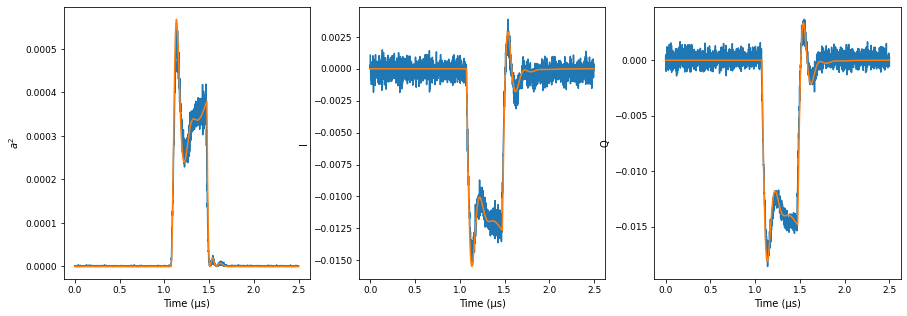

In [131]:

tplot = np.linspace(0, pumptime + decaytime +beforetime, len(asol2))
ratio = 6800*1e-7

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.plot(tdata, a2plot)
ax1.plot(tplot, ratio*asol2)
ax1.set_xlabel("Time (µs)")
ax1.set_ylabel("$a^2$")

ax2.plot(tdata, aplotr)
ax2.plot(tplot, np.sqrt(ratio)*asolr)
ax2.set_xlabel("Time (µs)")
ax2.set_ylabel("I")

ax3.plot(tdata, aploti)
ax3.plot(tplot, np.sqrt(ratio)*asoli)
ax3.set_xlabel("Time (µs)")
ax3.set_ylabel("Q")

In [100]:
def minimize_func(x):
    gcoll_min = gcoll*x[0]
    qval_min = q*x[1]
    gammaq_min = gammaq*x[2]
    ampl_min = ratio*x[3]
    phase = initphase*x[4]
    
    spins_min, gs_min, pdf_min = create_spins_inhomo_g(gcoll_min, g_list, qval_min, delta, gammaq_min, nbins, holes=False, inhomo=True, hyperfine=True)
    solpump, soldecay, infodict = solve_mbes(mbes, init, pdf_min, tlist, tlistdecay, etasteady*np.exp(1j*phase), kappa, deltac, gs_min, gperp, spins_min, gpar)
    asolr = np.sqrt(ampl_min)*np.hstack((np.zeros(int(beforetime/dt)), solpump[:,0].real, soldecay[:,0].real))
    asoli = np.sqrt(ampl_min)*np.hstack((np.zeros(int(beforetime/dt)), solpump[:,0].imag, soldecay[:,0].imag))
    
    res = 0
    for i, t in enumerate(tdata):
        idx = find_nearest_sorted(tplot, t)
        res += abs(aplotr[i]-asolr[idx])**2
        res += abs(aploti[i]-asoli[idx])**2
    return res


In [146]:
def callbackF(Xi):
    global Nfeval
    global minimize_func
    print('{0:4d}\t{1: 3.3f}\t{2: 3.4f}\t{3: 3.3f}\t{4: 3.0f}\t{5: 3.6f}\t{6: 3.6f}'.format(Nfeval, Xi[0]*gcoll, Xi[1]*q, Xi[2]*gammaq, Xi[3]*ratio, Xi[4]*initphase, minimize_func(Xi)))
    Nfeval += 1
print('{0:4s}\t{1:4s}\t{2:4s}\t{3:6s}\t{4:4s}\t{5:4s}\t{6:4s}'.format('Iter', ' X1', ' X2', ' X3', 'X4','X5', 'f(X)'))
Nfeval = 1
p0 = [1, 1, 1, 1, 1]
bnds = ((0, np.inf),(1,2), (0, np.inf), (0, np.inf))
res = minimize(minimize_func, x0=p0, method='Nelder-Mead', options={"disp":True}, callback=callbackF)








Iter	 X1 	 X2 	 X3   	X4  	X5  	f(X)
   1	 31.174	 1.8049	 48.181	 2500000000	 0.742201	 0.084812
   2	 31.174	 1.8049	 48.181	 2500000000	 0.742201	 0.084812
   3	 31.174	 1.8049	 48.181	 2500000000	 0.742201	 0.084812
   4	 31.174	 1.8049	 48.181	 2500000000	 0.742201	 0.084812
   5	 31.174	 1.8049	 48.181	 2500000000	 0.742201	 0.084812
   6	 31.174	 1.8049	 48.181	 2500000000	 0.742201	 0.084812
   7	 31.217	 1.7770	 45.787	 2608315200	 0.756484	 0.082800
   8	 31.217	 1.7770	 45.787	 2608315200	 0.756484	 0.082800
   9	 31.217	 1.7770	 45.787	 2608315200	 0.756484	 0.082800


KeyboardInterrupt: 

In [135]:
gcoll_optim = gcoll*res.x[0]
q_optim = q*res.x[1]
gammaq_optim = gammaq*res.x[2]
ampl = ratio*res.x[3]
phase = initphase*res.x[4]

spins_optim, gs_optim, pdf_optim = create_spins_inhomo_g(gcoll_optim, g_list, q_optim, delta, gammaq_optim, nbins, holes=False, inhomo=True, hyperfine=True)
solpump, soldecay, infodict = solve_mbes(mbes, init, pdf_optim, tlist, tlistdecay, np.exp(1j*phase)*etasteady, kappa, deltac, gs_optim, gperp, spins_optim, gpar)

asol2_optim = np.hstack((np.zeros(int(beforetime/dt)), abs(solpump[:,0])**2, abs(soldecay[:,0])**2))
asolr_optim = np.hstack((np.zeros(int(beforetime/dt)), solpump[:,0].real, soldecay[:,0].real))
asoli_optim = np.hstack((np.zeros(int(beforetime/dt)), solpump[:,0].imag, soldecay[:,0].imag))

31.174474083809773 1.8048699796219885 48.18060262895924
31.99831409585 1.976180662170014 46.85515520402958


Text(0, 0.5, 'Q')

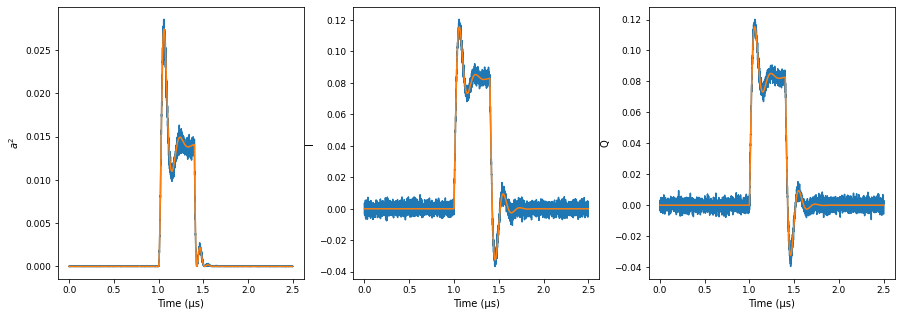

In [136]:
print(gcoll, q, gammaq)
print(gcoll_optim, q_optim, gammaq_optim)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.plot(tdata, a2plot)
ax1.plot(tplot, ampl*asol2)
ax1.set_xlabel("Time (µs)")
ax1.set_ylabel("$a^2$")

ax2.plot(tdata, aplotr)
ax2.plot(tplot, np.sqrt(ampl)*asolr_optim)
ax2.set_xlabel("Time (µs)")
ax2.set_ylabel("I")

ax3.plot(tdata, aploti)
ax3.plot(tplot, np.sqrt(ampl)*asoli_optim)
ax3.set_xlabel("Time (µs)")
ax3.set_ylabel("Q")